In [2]:
# import libraries
import time
import pandas as pd
import numpy as np
import string
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, make_scorer, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')

In [3]:
# load data from MIMIC
df_adm = pd.read_csv('../MMIC3/ADMISSIONS.csv')
df_adm.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [9]:
# format dates
df_adm.ADMITTIME = pd.to_datetime(df_adm.ADMITTIME, format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_adm.DISCHTIME = pd.to_datetime(df_adm.DISCHTIME, format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_adm.DEATHTIME = pd.to_datetime(df_adm.DEATHTIME, format='%Y-%m-%d %H:%M:%S', errors='coerce')

# sort by subject_ID and admission date
df_adm = df_adm.sort_values(['SUBJECT_ID', 'ADMITTIME'])
df_adm = df_adm.reset_index(drop=True)

# add next admission date and type for each subject using groupby
df_adm['NEXT_ADMITTIME'] = df_adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
df_adm['NEXT_ADMISSION_TYPE'] = df_adm.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

# get rows where next admission is elective and replace with nan
rows = df_adm.NEXT_ADMISSION_TYPE == 'ELECTIVE'
df_adm.loc[rows, 'NEXT_ADMITTIME'] = pd.NaT
df_adm.loc[rows, 'NEXT_ADMISSION_TYPE'] = np.NaN

# sort by subject_ID and admission date
df_adm = df_adm.sort_values(['SUBJECT_ID', 'ADMITTIME'])
df_adm[['NEXT_ADMITTIME', 'NEXT_ADMISSION_TYPE']] = df_adm.groupby(['SUBJECT_ID'])[
    ['NEXT_ADMITTIME', 'NEXT_ADMISSION_TYPE']].fillna(method='bfill')

# calculate days until next admission
df_adm['DAYS_NEXT_ADMIT'] = (df_adm.NEXT_ADMITTIME - df_adm.DISCHTIME).dt.total_seconds() / (24 * 60 * 60)

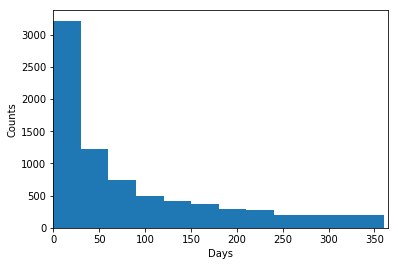

In [11]:
plt.hist(df_adm.loc[~df_adm.DAYS_NEXT_ADMIT.isnull(), 'DAYS_NEXT_ADMIT'], bins=range(0, 365, 30))
plt.xlim([0, 365])
plt.xlabel('Days')
plt.ylabel('Counts')
plt.show()

In [12]:
# load Clinical notes from MIMIC
df_notes = pd.read_csv("../MMIC3/NOTEEVENTS.csv")

/home/rasool/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
# Clinical notes types
df_notes.CATEGORY.unique()

array(['Discharge summary', 'Echo', 'ECG', 'Nursing', 'Physician ',
       'Rehab Services', 'Case Management ', 'Respiratory ', 'Nutrition',
       'General', 'Social Work', 'Pharmacy', 'Consult', 'Radiology',
       'Nursing/other'], dtype=object)

In [15]:
df_notes.head().T

,0,1,2,3,4
ROW_ID,174,175,176,177,178
SUBJECT_ID,22532,13702,13702,13702,26880
HADM_ID,167853,107527,167118,196489,135453
CHARTDATE,2151-08-04,2118-06-14,2119-05-25,2124-08-18,2162-03-25
CHARTTIME,NaN,NaN,NaN,NaN,NaN
STORETIME,NaN,NaN,NaN,NaN,NaN
CATEGORY,Discharge summary,Discharge summary,Discharge summary,Discharge summary,Discharge summary
DESCRIPTION,Report,Report,Report,Report,Report
CGID,NaN,NaN,NaN,NaN,NaN
ISERROR,NaN,NaN,NaN,NaN,NaN


In [17]:
# filter to discharge summary
df_notes_dis_sum = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']
df_notes_dis_sum_last = (df_notes_dis_sum.groupby(['SUBJECT_ID', 'HADM_ID']).nth(-1)).reset_index()

# join admission and discharge summary
df_adm_notes = pd.merge(df_adm[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DAYS_NEXT_ADMIT', 'NEXT_ADMITTIME',
                                'ADMISSION_TYPE', 'DEATHTIME']],
                        df_notes_dis_sum_last[['SUBJECT_ID', 'HADM_ID', 'TEXT']],
                        on=['SUBJECT_ID', 'HADM_ID'],
                        how='left')

df_adm_notes.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum()) / df_adm_notes.groupby(
    'ADMISSION_TYPE').size()
df_adm_notes_clean = df_adm_notes.loc[df_adm_notes.ADMISSION_TYPE != 'NEWBORN'].copy()

# set label based on 30 Days readmission
df_adm_notes_clean['OUTPUT_LABEL'] = (df_adm_notes_clean.DAYS_NEXT_ADMIT < 30).astype('int')

In [22]:
print('positive samples:', (df_adm_notes_clean.OUTPUT_LABEL == 1).sum())
print('negative samples:', (df_adm_notes_clean.OUTPUT_LABEL == 0).sum())
print('Total samples:', len(df_adm_notes_clean))

positive samples: 3004
negative samples: 48109
Total samples: 51113


In [23]:
# split data into train, validation and test
df_adm_notes_clean = df_adm_notes_clean.sample(n=len(df_adm_notes_clean), random_state=42)
df_adm_notes_clean = df_adm_notes_clean.reset_index(drop=True)
df_valid_test = df_adm_notes_clean.sample(frac=0.30, random_state=42)

df_test = df_valid_test.sample(frac=0.5, random_state=42)
df_valid = df_valid_test.drop(df_test.index)
df_train_all = df_adm_notes_clean.drop(df_valid_test.index)

rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

df_train = pd.concat([df_train_pos, df_train_neg.sample(n=len(df_train_pos), random_state=42)], axis=0)
df_train = df_train.sample(n=len(df_train), random_state=42).reset_index(drop=True)

In [26]:
def preprocess_text(df):
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT = df.TEXT.str.replace('\n', ' ')
    df.TEXT = df.TEXT.str.replace('\r', ' ')
    return df


def tokenizer_better(text):
    punc_list = string.punctuation + '0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

In [27]:
df_train = preprocess_text(df_train)
df_valid = preprocess_text(df_valid)
df_test = preprocess_text(df_test)

In [32]:
# bag of words
vect = CountVectorizer(max_features=3000, tokenizer=tokenizer_better)
vect.fit(df_train.TEXT.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=3000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenizer_better at 0x7f0d17ffc9d8>,
        vocabulary=None)

In [33]:
# plot word frequency
neg_doc_matrix = vect.transform(df_train[df_train.OUTPUT_LABEL == 0].TEXT)
pos_doc_matrix = vect.transform(df_train[df_train.OUTPUT_LABEL == 1].TEXT)
neg_tf = np.sum(neg_doc_matrix, axis=0)
pos_tf = np.sum(pos_doc_matrix, axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg, pos], columns=vect.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
the,71054,76756,147810
and,62455,71658,134113
to,53226,62085,115311
of,51303,60491,111794
was,48074,53521,101595
with,38036,44583,82619
a,35428,41629,77057
on,32290,39765,72055
mg,27718,39045,66763
in,29567,34755,64322


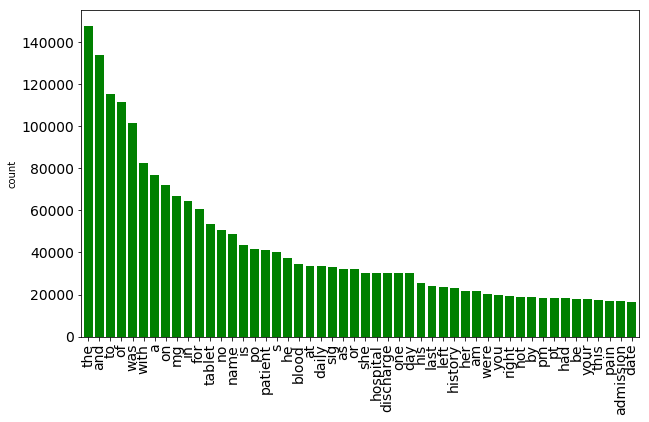

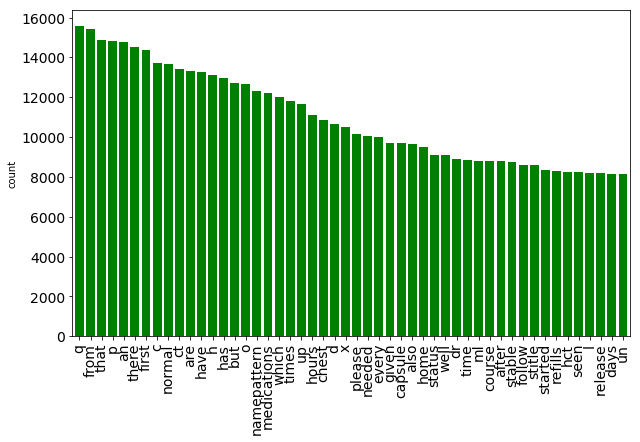

In [34]:
# plot word frequency
d = pd.Series(term_freq_df.total,
              index=term_freq_df.index).sort_values(ascending=False)
ax = d[:50].plot(kind='bar', figsize=(10, 6), width=.8, fontsize=14, rot=90, color='g')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()
ax = d[50:100].plot(kind='bar', figsize=(10, 6), width=.8, fontsize=14, rot=90, color='g')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()

In [35]:
my_stop_words = ['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on', 'in', 'for', 'name',
                 'is', 'patient', 's', 'he', 'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am',
                 'were', 'you', 'pt', 'pm', 'by', 'be', 'had', 'your', 'this', 'date',
                 'from', 'there', 'an', 'that', 'p', 'are', 'have', 'has', 'h', 'but', 'o',
                 'namepattern', 'which', 'every', 'also', 'q', 'c', 'x', 'd']

In [36]:
# bag of words removing stop words
vect = CountVectorizer(max_features=3000,
                       tokenizer=tokenizer_better,
                       stop_words=my_stop_words)
vect.fit(df_train.TEXT.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=3000, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on', 'in', 'for', 'name', 'is', 'patient', 's', 'he', 'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am', 'were', 'you', 'pt', 'pm', 'by', 'be', 'had', 'your', 'this', 'date', 'from', 'there', 'an', 'that', 'p', 'are', 'have', 'has', 'h', 'but', 'o', 'namepattern', 'which', 'every', 'also', 'q', 'c', 'x', 'd'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenizer_better at 0x7f0d17ffc9d8>,
        vocabulary=None)

In [38]:
neg_doc_matrix = vect.transform(df_train[df_train.OUTPUT_LABEL == 0].TEXT)
pos_doc_matrix = vect.transform(df_train[df_train.OUTPUT_LABEL == 1].TEXT)
neg_tf = np.sum(neg_doc_matrix, axis=0)
pos_tf = np.sum(pos_doc_matrix, axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

In [39]:
term_freq_df = pd.DataFrame([pos], columns=vect.get_feature_names()).transpose()
term_freq_df.columns = ['positive']
term_freq_df['total'] = term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,positive,total
mg,39045,39045
tablet,30760,30760
no,25902,25902
po,24694,24694
daily,19642,19642
sig,19417,19417
blood,18433,18433
day,17116,17116
hospital,16888,16888
discharge,15777,15777


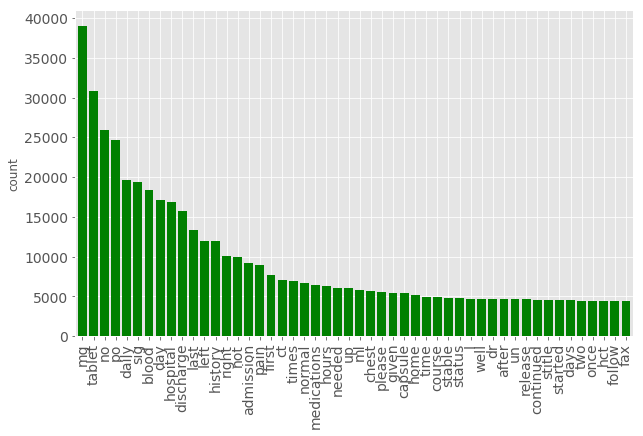

In [41]:
# plot word frequency removing stop words
d = pd.Series(term_freq_df.total,
              index=term_freq_df.index).sort_values(ascending=False)
ax = d[:50].plot(kind='bar', figsize=(10, 6), width=.8, fontsize=14, rot=90, color='g')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()

In [42]:
term_freq_df = pd.DataFrame([neg], columns=vect.get_feature_names()).transpose()
term_freq_df.columns = ['negative']
term_freq_df['total'] = term_freq_df['negative']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,total
mg,27718,27718
no,24760,24760
tablet,22582,22582
po,16902,16902
blood,16127,16127
discharge,14530,14530
daily,13736,13736
sig,13648,13648
hospital,13446,13446
day,12963,12963


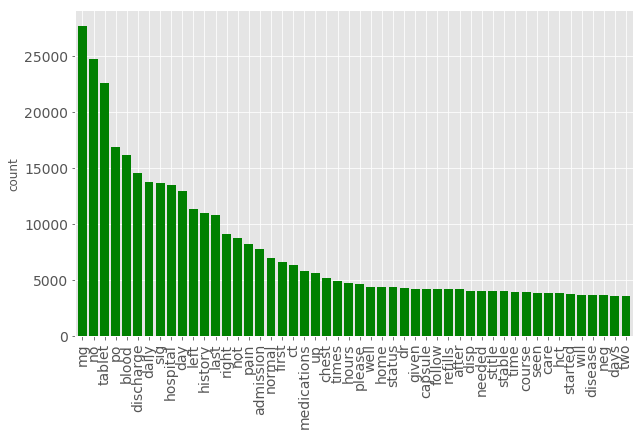

In [43]:
d = pd.Series(term_freq_df.total,
              index=term_freq_df.index).sort_values(ascending=False)
ax = d[:50].plot(kind='bar', figsize=(10, 6), width=.8, fontsize=14, rot=90, color='g')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()

In [44]:
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)

y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL

In [45]:
# calculation of metrics

def calc_accuracy(y_actual, y_pred, thresh):
    return (sum((y_pred > thresh) & (y_actual == 1)) + sum((y_pred < thresh) & (y_actual == 0))) / len(y_actual)


def calc_recall(y_actual, y_pred, thresh):
    return sum((y_pred > thresh) & (y_actual == 1)) / sum(y_actual)


def calc_precision(y_actual, y_pred, thresh):
    return sum((y_pred > thresh) & (y_actual == 1)) / sum(y_pred > thresh)


def calc_specificity(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) / sum(y_actual == 0)


def calc_prevalence(y_actual):
    return sum((y_actual == 1)) / len(y_actual)


def calc_specificity(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) / sum(y_actual == 0)


def print_report(y_actual, y_pred, thresh):
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f' % auc)
    print('accuracy:%.3f' % accuracy)
    print('recall:%.3f' % recall)
    print('precision:%.3f' % precision)
    print('specificity:%.3f' % specificity)
    print('prevalence:%.3f' % calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [46]:
my_new_stop_words = ['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on', 'in', 'for', 'name',
                     'is', 'patient', 's', 'he', 'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am',
                     'were', 'you', 'pt', 'pm', 'by', 'be', 'had', 'your', 'this', 'date',
                     'from', 'there', 'an', 'that', 'p', 'are', 'have', 'has', 'h', 'but', 'o',
                     'namepattern', 'which', 'every', 'also', 'should', 'if', 'it', 'been', 'who', 'during', 'x', 'q',
                     'c', 'x', 'd']

In [47]:
# bag of words removing new stop words
vect = CountVectorizer(lowercase=True, max_features=3000,
                       tokenizer=tokenizer_better,
                       stop_words=my_new_stop_words)

vect.fit(df_train.TEXT.values)

X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
X_test_tf = vect.transform(df_test.TEXT.values)

y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL
y_test = df_test.OUTPUT_LABEL

In [49]:
# logistic regression
lr = LogisticRegression(random_state=42)
lr.fit(X_train_tf, y_train)

/home/rasool/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [52]:
thresh = 0.5

y_train_preds = lr.predict_proba(X_train_tf)[:, 1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:, 1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train, y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid, y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.999
accuracy:0.984
recall:0.976
precision:0.993
specificity:0.993
prevalence:0.500
 
Validation:
AUC:0.628
accuracy:0.607
recall:0.577
precision:0.082
specificity:0.609
prevalence:0.057
 


In [53]:
# k-nearest neighbors
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [54]:
y_train_preds = knn.predict_proba(X_train_tf)[:, 1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:, 1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = print_report(y_train, y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid, y_valid_preds, thresh)

KNN
Training:
AUC:0.761
accuracy:0.673
recall:0.525
precision:0.745
specificity:0.685
prevalence:0.500
 
Validation:
AUC:0.664
accuracy:0.741
recall:0.474
precision:0.105
specificity:0.600
prevalence:0.057
 


In [55]:
# Decision Tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [56]:
y_train_preds = tree.predict_proba(X_train_tf)[:, 1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:, 1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity = print_report(
    y_train, y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity = print_report(
    y_valid, y_valid_preds, thresh)

Decision Tree
Training:
AUC:1.000
accuracy:0.990
recall:0.979
precision:1.000
specificity:1.000
prevalence:0.500
 
Validation:
AUC:0.593
accuracy:0.593
recall:0.597
precision:0.081
specificity:0.592
prevalence:0.057
 


In [57]:
# RandomForest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tf, y_train)

/home/rasool/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [58]:
y_train_preds = rf.predict_proba(X_train_tf)[:, 1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:, 1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity = print_report(y_train,
                                                                                                          y_train_preds,
                                                                                                          thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,
                                                                                                          y_valid_preds,
                                                                                                          thresh)

Random Forest
Training:
AUC:0.997
accuracy:0.978
recall:0.960
precision:0.996
specificity:0.973
prevalence:0.500
 
Validation:
AUC:0.646
accuracy:0.671
recall:0.517
precision:0.089
specificity:0.511
prevalence:0.057
 


In [59]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [60]:
y_train_preds = gbc.predict_proba(X_train_tf)[:, 1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:, 1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity = print_report(y_train,
                                                                                                               y_train_preds,
                                                                                                               thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity = print_report(y_valid,
                                                                                                               y_valid_preds,
                                                                                                               thresh)

Gradient Boosting Classifier
Training:
AUC:0.988
accuracy:0.940
recall:0.932
precision:0.948
specificity:0.949
prevalence:0.500
 
Validation:
AUC:0.663
accuracy:0.623
recall:0.613
precision:0.090
specificity:0.623
prevalence:0.057
 


In [61]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train_tf.toarray(), y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [62]:
y_train_preds = nb.predict_proba(X_train_tf.toarray())[:, 1]
y_valid_preds = nb.predict_proba(X_valid_tf.toarray())[:, 1]

print('Naive Bayes')
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity = print_report(y_train,
                                                                                                          y_train_preds,
                                                                                                          thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = print_report(y_valid,
                                                                                                          y_valid_preds,
                                                                                                          thresh)

Naive Bayes
Training:
AUC:0.714
accuracy:0.661
recall:0.564
precision:0.700
specificity:0.759
prevalence:0.500
 
Validation:
AUC:0.668
accuracy:0.709
recall:0.538
precision:0.104
specificity:0.720
prevalence:0.057
 


In [63]:
# Stochastic Gradient Descend
sgdc = SGDClassifier(loss='log', alpha=0.1, random_state=42)
sgdc.fit(X_train_tf, y_train)

/home/rasool/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.1, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [64]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:, 1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:, 1]

print('Stochastic Gradient Descend')
print('Training:')
sgdc_train_auc, sgdc_train_accuracy, sgdc_train_recall, sgdc_train_precision, sgdc_train_specificity = print_report(
    y_train, y_train_preds, thresh)
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, sgdc_valid_precision, sgdc_valid_specificity = print_report(
    y_valid, y_valid_preds, thresh)

Stochastic Gradient Descend
Training:
AUC:0.805
accuracy:0.661
recall:0.382
precision:0.864
specificity:0.940
prevalence:0.500
 
Validation:
AUC:0.613
accuracy:0.830
recall:0.288
precision:0.113
specificity:0.863
prevalence:0.057
 


In [65]:
# join all results
df_results = pd.DataFrame(
    {'classifier': ['KNN', 'KNN', 'LR', 'LR', 'SGD', 'SGD', 'NB', 'NB', 'DT', 'DT', 'RF', 'RF', 'GB', 'GB'],
     'data_set': ['train', 'valid'] * 7,
     'auc': [knn_train_auc, knn_valid_auc, lr_train_auc, lr_valid_auc, sgdc_train_auc, sgdc_valid_auc, nb_train_auc,
             nb_valid_auc, tree_train_auc, tree_valid_auc, rf_train_auc, rf_valid_auc, gbc_valid_auc, gbc_valid_auc, ],
     'accuracy': [knn_train_accuracy, knn_valid_accuracy, lr_train_accuracy, lr_valid_accuracy, sgdc_train_accuracy,
                  sgdc_valid_accuracy, nb_train_accuracy, nb_valid_accuracy, tree_train_accuracy, tree_valid_accuracy,
                  rf_train_accuracy, rf_valid_accuracy, gbc_valid_accuracy, gbc_valid_accuracy, ],
     'recall': [knn_train_recall, knn_valid_recall, lr_train_recall, lr_valid_recall, sgdc_train_recall,
                sgdc_valid_recall, nb_train_recall, nb_valid_recall, tree_train_recall, tree_valid_recall,
                rf_train_recall, rf_valid_recall, gbc_valid_recall, gbc_valid_recall, ],
     'precision': [knn_train_precision, knn_valid_precision, lr_train_precision, lr_valid_precision,
                   sgdc_train_precision, sgdc_valid_precision, nb_train_precision, nb_valid_precision,
                   tree_train_precision, tree_valid_precision, rf_train_precision, rf_valid_precision, gbc_valid_auc,
                   gbc_valid_precision, ],
     'specificity': [knn_train_specificity, knn_valid_specificity, lr_train_specificity, lr_valid_specificity,
                     sgdc_train_specificity, sgdc_valid_specificity, nb_train_specificity, nb_valid_specificity,
                     tree_train_specificity, tree_valid_specificity, rf_train_specificity, rf_valid_specificity,
                     gbc_valid_specificity, gbc_valid_specificity, ]})

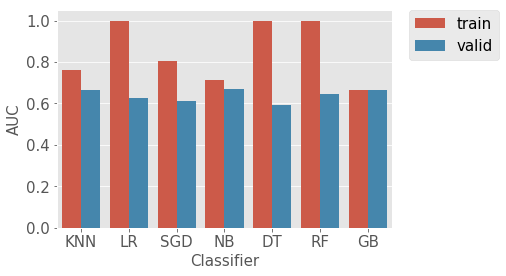

In [67]:
# plot results
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier', fontsize=15)
ax.set_ylabel('AUC', fontsize=15)
ax.tick_params(labelsize=15)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
plt.show()

In [68]:
# random search for hyperparameters
Cs = [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003]

random_grid = {'C': Cs}
auc_scoring = make_scorer(roc_auc_score)
lr_random = RandomizedSearchCV(estimator=lr, param_distributions=random_grid,
                               n_iter=20, cv=5, scoring=auc_scoring,
                               verbose=1, random_state=42)
print(random_grid)

{'C': [1e-05, 3e-05, 0.0001, 0.0003, 0.001, 0.003]}


In [ ]:
t1 = time.time()
lr_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2 - t1)

In [72]:
lr_random.best_params_

{'C': 0.0003}

In [73]:
y_train_preds = lr.predict_proba(X_train_tf)[:, 1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:, 1]

print('Baseline Logistic Regresion')
lr_train_auc_base = roc_auc_score(y_train, y_train_preds)
lr_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f' % (lr_train_auc_base))
print('Validation AUC:%.3f' % (lr_valid_auc_base))

print('Optimized Logistic Regresion')
y_train_preds_random = lr_random.best_estimator_.predict_proba(X_train_tf)[:, 1]
y_valid_preds_random = lr_random.best_estimator_.predict_proba(X_valid_tf)[:, 1]

lr_train_auc = roc_auc_score(y_train, y_train_preds_random)
lr_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f' % (lr_train_auc))
print('Validation AUC:%.3f' % (lr_valid_auc))

Baseline Logistic Regresion
Training AUC:0.999
Validation AUC:0.628
Optimized Logistic Regresion
Training AUC:0.796
Validation AUC:0.715


In [ ]:
# random forest hyperparameters

# number of trees
n_estimators = range(50, 500, 50)
# maximum number of features to use at each split
max_features = ['auto', 'sqrt']
# maximum depth of the tree
max_depth = range(1, 20, 2)
# minimum number of samples to split a node
min_samples_split = range(2, 20, 2)
# criterion for evaluating a split
criterion = ['gini', 'entropy']

# random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'criterion': criterion}

auc_scoring = make_scorer(roc_auc_score)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter=20, cv=5, scoring=auc_scoring,
                               verbose=1, random_state=42, n_jobs=-1)
print(random_grid)

In [77]:
t1 = time.time()
rf_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2 - t1)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished


239.6144895553589


In [78]:
rf_random.best_params_

{'criterion': 'entropy',
 'max_depth': 19,
 'max_features': 'sqrt',
 'min_samples_split': 4,
 'n_estimators': 350}

In [79]:
y_train_preds = rf.predict_proba(X_train_tf)[:, 1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:, 1]

print('Baseline Random Forest')
rf_train_auc_base = roc_auc_score(y_train, y_train_preds)
rf_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f' % (rf_train_auc_base))
print('Validation AUC:%.3f' % (rf_valid_auc_base))

print('Optimized Random Forest')
y_train_preds_random = rf_random.best_estimator_.predict_proba(X_train_tf)[:, 1]
y_valid_preds_random = rf_random.best_estimator_.predict_proba(X_valid_tf)[:, 1]

rf_train_auc = roc_auc_score(y_train, y_train_preds_random)
rf_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f' % (rf_train_auc))
print('Validation AUC:%.3f' % (rf_valid_auc))

Baseline Random Forest
Training AUC:0.997
Validation AUC:0.646
Optimized Random Forest
Training AUC:0.997
Validation AUC:0.723


In [80]:
# stochastic gradient descend hyperparameters
penalty = ['none', 'l2', 'l1']
max_iter = range(50, 500, 50)
alpha = [0.0001, 0.01, 0.03, 0.1, 0.3, 0.4, 0.5, 0.7, 0.9]
random_grid_sgdc = {'penalty': penalty,
                    'max_iter': max_iter,
                    'alpha': alpha}

sgdc_random = RandomizedSearchCV(estimator=sgdc, param_distributions=random_grid_sgdc,
                                 n_iter=20, cv=5, scoring=auc_scoring, verbose=0,
                                 random_state=42, n_jobs=-1)

t1 = time.time()
sgdc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2 - t1)

95.2521743774414


In [81]:
sgdc_random.best_params_

{'alpha': 0.9, 'max_iter': 400, 'penalty': 'l2'}

In [82]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:, 1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:, 1]

print('Baseline sgdc')
sgdc_train_auc_base = roc_auc_score(y_train, y_train_preds)
sgdc_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f' % (sgdc_train_auc_base))
print('Validation AUC:%.3f' % (sgdc_valid_auc_base))
print('Optimized sgdc')
y_train_preds_random = sgdc_random.best_estimator_.predict_proba(X_train_tf)[:, 1]
y_valid_preds_random = sgdc_random.best_estimator_.predict_proba(X_valid_tf)[:, 1]
sgdc_train_auc = roc_auc_score(y_train, y_train_preds_random)
sgdc_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f' % (sgdc_train_auc))
print('Validation AUC:%.3f' % (sgdc_valid_auc))

Baseline sgdc
Training AUC:0.805
Validation AUC:0.613
Optimized sgdc
Training AUC:0.791
Validation AUC:0.715


In [83]:
# gradient boosting classifier hyperparameters

# number of trees
n_estimators = range(200, 350, 50)
# maximum depth of the tree
max_depth = range(1, 4, 1)
# learning rate
learning_rate = [0.1, 0.15, 0.2, 0.3]

random_grid_gbc = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'learning_rate': learning_rate}

# create the randomized search cross-validation
gbc_random = RandomizedSearchCV(estimator=gbc, param_distributions=random_grid_gbc,
                                n_iter=20, cv=2, scoring=auc_scoring,
                                verbose=2, random_state=42, n_jobs=-1)

t1 = time.time()
gbc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2 - t1)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.9min finished


264.2717990875244


In [84]:
gbc_random.best_params_

{'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 250}

In [85]:
y_train_preds = gbc.predict_proba(X_train_tf)[:, 1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:, 1]

print('Baseline gbc')
gbc_train_auc_base = roc_auc_score(y_train, y_train_preds)
gbc_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f' % (gbc_train_auc_base))
print('Validation AUC:%.3f' % (gbc_valid_auc_base))

print('Optimized gbc')
y_train_preds_random = gbc_random.best_estimator_.predict_proba(X_train_tf)[:, 1]
y_valid_preds_random = gbc_random.best_estimator_.predict_proba(X_valid_tf)[:, 1]
gbc_train_auc = roc_auc_score(y_train, y_train_preds_random)
gbc_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f' % (gbc_train_auc))
print('Validation AUC:%.3f' % (gbc_valid_auc))

Baseline gbc
Training AUC:0.988
Validation AUC:0.663
Optimized gbc
Training AUC:0.824
Validation AUC:0.711


In [86]:
# k-nearest neighbors hyperparameters

# number of trees
n_neighbors = range(30, 70, 10)
# random grid
random_grid_knn = {'n_neighbors': n_neighbors}

# create the randomized search cross-validation
knn_random = RandomizedSearchCV(estimator=knn, param_distributions=random_grid_knn,
                                n_iter=20, cv=5, scoring=auc_scoring,
                                verbose=2, random_state=42, n_jobs=-1)

t1 = time.time()
knn_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2 - t1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/rasool/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:   41.6s remaining:   10.4s


51.577139377593994


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   51.6s finished


In [87]:
knn_random.best_params_

{'n_neighbors': 50}

In [88]:
y_train_preds = knn.predict_proba(X_train_tf)[:, 1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:, 1]

print('Baseline knn')
knn_train_auc_base = roc_auc_score(y_train, y_train_preds)
knn_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f' % (knn_train_auc_base))
print('Validation AUC:%.3f' % (knn_valid_auc_base))

print('Optimized knn')
y_train_preds_random = knn_random.best_estimator_.predict_proba(X_train_tf)[:, 1]
y_valid_preds_random = knn_random.best_estimator_.predict_proba(X_valid_tf)[:, 1]
knn_train_auc = roc_auc_score(y_train, y_train_preds_random)
knn_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f' % (gbc_train_auc))
print('Validation AUC:%.3f' % (gbc_valid_auc))

Baseline knn
Training AUC:0.761
Validation AUC:0.664
Optimized knn
Training AUC:0.824
Validation AUC:0.711


In [89]:
# join optimized results
df_results = pd.DataFrame({'classifier': ['SGD', 'SGD', 'RF', 'RF', 'GB', 'GB', 'LR', 'LR', 'KNN', 'KNN'],
                           'data_set': ['base', 'optimized'] * 5,
                           'auc': [sgdc_valid_auc_base, sgdc_valid_auc,
                                   rf_valid_auc_base, rf_valid_auc,
                                   gbc_valid_auc_base, gbc_valid_auc,
                                   lr_valid_auc_base, lr_valid_auc,
                                   knn_valid_auc_base, knn_valid_auc],
                           })

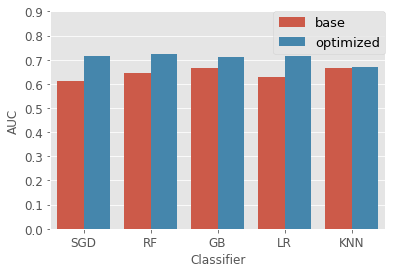

In [91]:
# plot results
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier', fontsize=12)
ax.set_ylabel('AUC', fontsize=12)
ax.tick_params(labelsize=12)

plt.setp(ax, yticks=np.arange(0, 1, step=0.1))
plt.legend(loc='upper right', borderaxespad=0., fontsize=13)

plt.show()

In [92]:
X_test_tf = vect.transform(df_test.TEXT.values)
y_test = df_test.OUTPUT_LABEL

In [93]:
model = rf_random.best_estimator_
y_train_preds = model.predict_proba(X_train_tf)[:, 1]
y_valid_preds = model.predict_proba(X_valid_tf)[:, 1]
y_test_preds = model.predict_proba(X_test_tf)[:, 1]

Train prevalence(n = 4184): 0.500
Valid prevalence(n = 7667): 0.057
Test prevalence(n = 7667): 0.062
Train AUC:0.791
Valid AUC:0.715
Test AUC:0.691
Train accuracy:0.722
Valid accuracy:0.672
Test accuracy:0.673
Train recall:0.703
Valid recall:0.654
Test recall:0.632
Train precision:0.730
Valid precision:0.108
Test precision:0.114
Train specificity:0.740
Valid specificity:0.673
Test specificity:0.675


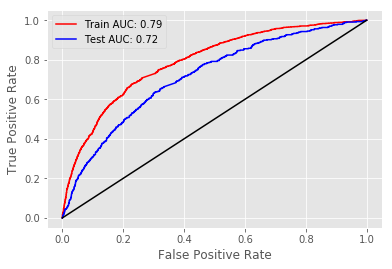

In [94]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

model = sgdc_random.best_estimator_
y_train_preds = model.predict_proba(X_train_tf)[:, 1]
y_valid_preds = model.predict_proba(X_valid_tf)[:, 1]
y_test_preds = model.predict_proba(X_test_tf)[:, 1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)

thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

print('Train prevalence(n = %d): %.3f' % (len(y_train), sum(y_train) / len(y_train)))
print('Valid prevalence(n = %d): %.3f' % (len(y_valid), sum(y_valid) / len(y_valid)))
print('Test prevalence(n = %d): %.3f' % (len(y_test), sum(y_test) / len(y_test)))

print('Train AUC:%.3f' % auc_train)
print('Valid AUC:%.3f' % auc_valid)
print('Test AUC:%.3f' % auc_test)

print('Train accuracy:%.3f' % calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f' % calc_accuracy(y_valid, y_valid_preds, thresh))
print('Test accuracy:%.3f' % calc_accuracy(y_test, y_test_preds, thresh))

print('Train recall:%.3f' % calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f' % calc_recall(y_valid, y_valid_preds, thresh))
print('Test recall:%.3f' % calc_recall(y_test, y_test_preds, thresh))

print('Train precision:%.3f' % calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f' % calc_precision(y_valid, y_valid_preds, thresh))
print('Test precision:%.3f' % calc_precision(y_test, y_test_preds, thresh))

print('Train specificity:%.3f' % calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f' % calc_specificity(y_valid, y_valid_preds, thresh))
print('Test specificity:%.3f' % calc_specificity(y_test, y_test_preds, thresh))

plt.plot(fpr_train, tpr_train, 'r-', label='Train AUC: %.2f' % auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-', label='Test AUC: %.2f' % auc_valid)

plt.plot([0, 1], [0, 1], '-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Train prevalence(n = 4184): 0.500
Valid prevalence(n = 7667): 0.057
Test prevalence(n = 7667): 0.062
Train AUC:0.796
Valid AUC:0.715
Test AUC:0.692
Train accuracy:0.727
Valid accuracy:0.679
Test accuracy:0.679
Train recall:0.700
Valid recall:0.645
Test recall:0.619
Train precision:0.740
Valid precision:0.109
Test precision:0.114
Train specificity:0.754
Valid specificity:0.681
Test specificity:0.683


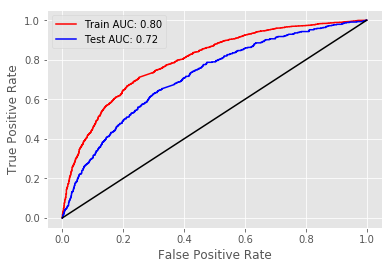

In [95]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

model = lr_random.best_estimator_
y_train_preds = model.predict_proba(X_train_tf)[:, 1]
y_valid_preds = model.predict_proba(X_valid_tf)[:, 1]
y_test_preds = model.predict_proba(X_test_tf)[:, 1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)

thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

print('Train prevalence(n = %d): %.3f' % (len(y_train), sum(y_train) / len(y_train)))
print('Valid prevalence(n = %d): %.3f' % (len(y_valid), sum(y_valid) / len(y_valid)))
print('Test prevalence(n = %d): %.3f' % (len(y_test), sum(y_test) / len(y_test)))

print('Train AUC:%.3f' % auc_train)
print('Valid AUC:%.3f' % auc_valid)
print('Test AUC:%.3f' % auc_test)

print('Train accuracy:%.3f' % calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f' % calc_accuracy(y_valid, y_valid_preds, thresh))
print('Test accuracy:%.3f' % calc_accuracy(y_test, y_test_preds, thresh))

print('Train recall:%.3f' % calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f' % calc_recall(y_valid, y_valid_preds, thresh))
print('Test recall:%.3f' % calc_recall(y_test, y_test_preds, thresh))

print('Train precision:%.3f' % calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f' % calc_precision(y_valid, y_valid_preds, thresh))
print('Test precision:%.3f' % calc_precision(y_test, y_test_preds, thresh))

print('Train specificity:%.3f' % calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f' % calc_specificity(y_valid, y_valid_preds, thresh))
print('Test specificity:%.3f' % calc_specificity(y_test, y_test_preds, thresh))

plt.plot(fpr_train, tpr_train, 'r-', label='Train AUC: %.2f' % auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-', label='Test AUC: %.2f' % auc_valid)

plt.plot([0, 1], [0, 1], '-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Train prevalence(n = 4184): 0.500
Valid prevalence(n = 7667): 0.057
Test prevalence(n = 7667): 0.062
Train AUC:0.824
Valid AUC:0.711
Test AUC:0.691
Train accuracy:0.744
Valid accuracy:0.680
Test accuracy:0.685
Train recall:0.717
Valid recall:0.629
Test recall:0.604
Train precision:0.759
Valid precision:0.107
Test precision:0.114
Train specificity:0.772
Valid specificity:0.683
Test specificity:0.690


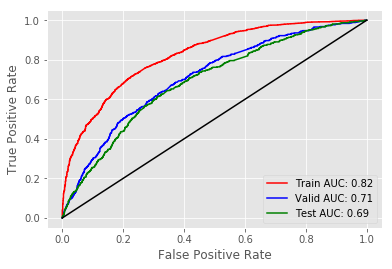

In [96]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

model = gbc_random.best_estimator_
y_train_preds = model.predict_proba(X_train_tf)[:, 1]
y_valid_preds = model.predict_proba(X_valid_tf)[:, 1]
y_test_preds = model.predict_proba(X_test_tf)[:, 1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)

thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

print('Train prevalence(n = %d): %.3f' % (len(y_train), sum(y_train) / len(y_train)))
print('Valid prevalence(n = %d): %.3f' % (len(y_valid), sum(y_valid) / len(y_valid)))
print('Test prevalence(n = %d): %.3f' % (len(y_test), sum(y_test) / len(y_test)))

print('Train AUC:%.3f' % auc_train)
print('Valid AUC:%.3f' % auc_valid)
print('Test AUC:%.3f' % auc_test)

print('Train accuracy:%.3f' % calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f' % calc_accuracy(y_valid, y_valid_preds, thresh))
print('Test accuracy:%.3f' % calc_accuracy(y_test, y_test_preds, thresh))

print('Train recall:%.3f' % calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f' % calc_recall(y_valid, y_valid_preds, thresh))
print('Test recall:%.3f' % calc_recall(y_test, y_test_preds, thresh))

print('Train precision:%.3f' % calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f' % calc_precision(y_valid, y_valid_preds, thresh))
print('Test precision:%.3f' % calc_precision(y_test, y_test_preds, thresh))

print('Train specificity:%.3f' % calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f' % calc_specificity(y_valid, y_valid_preds, thresh))
print('Test specificity:%.3f' % calc_specificity(y_test, y_test_preds, thresh))

plt.plot(fpr_train, tpr_train, 'r-', label='Train AUC: %.2f' % auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-', label='Valid AUC: %.2f' % auc_valid)
plt.plot(fpr_test, tpr_test, 'g-', label='Test AUC: %.2f' % auc_test)

plt.plot([0, 1], [0, 1], '-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

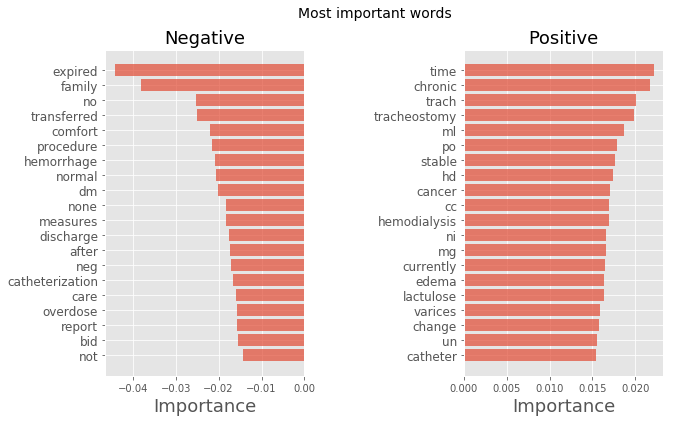

In [98]:
# plot feature importance
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v: k for k, v in vectorizer.vocabulary_.items()}

    # loop for each class
    classes = {}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i, el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key=lambda x: x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key=lambda x: x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops': tops,
            'bottom': bottom
        }
    return classes


def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a, b) for a, b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])

    bottom_pairs = [(a, b) for a, b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]

    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]

    fig = plt.figure(figsize=(10, 6))

    plt.subplot(121)
    plt.barh(y_pos, bottom_scores, align='center', alpha=0.7)
    plt.title('Negative', fontsize=18)
    plt.yticks(y_pos, bottom_words, fontsize=12)
    plt.suptitle('Key words', fontsize=14)
    plt.xlabel('Importance', fontsize=18)

    plt.subplot(122)
    plt.barh(y_pos, top_scores, align='center', alpha=0.7)
    plt.title('Positive', fontsize=18)
    plt.yticks(y_pos, top_words, fontsize=12)
    plt.suptitle(name, fontsize=14)
    plt.xlabel('Importance', fontsize=18)

    plt.subplots_adjust(wspace=0.8)
    plt.show()


importance = get_most_important_features(vect, lr_random.best_estimator_, 20)

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words")